# EMPIRICAL TRANSFER FUNCTIONS

## Preliminaries

In [1]:
import controlSBML as ctl

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
ctl.__version__

'1.0.5'

## Models

### SIMPLE_MODEL

In [2]:
SIMPLE_MODEL = """
species E1;
J1: S1 -> S2; S1 + E1
S1 = 10; S2 = 0; E1 = 0;
"""

### SIMPLE_OLS_MODEL

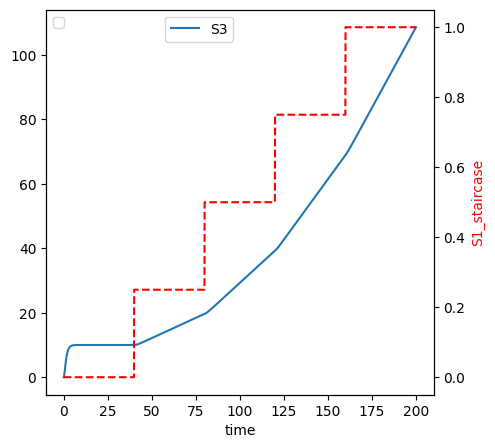

In [3]:
SIMPLE_OLS_MODEL = """
J0: $S0 -> S1; k0*$S0
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
S1 = 10; S2 = 0; S3 = 0
k0 =20
k1 = 1
k2 = 2
"""
rr = te.loada(SIMPLE_OLS_MODEL)
SIMPLE_OLS_CTLSB = ctl.ControlSBML(SIMPLE_OLS_MODEL, input_names=["S1"], output_names=["S3"])
SIMPLE_OLS_SYS = SIMPLE_OLS_CTLSB.makeNonlinearIOSystem("simple_ols_sys")
SIMPLE_OLS_PR = SIMPLE_OLS_SYS.plotStaircaseResponse(initial_value=0, final_value=1, num_step=5, end_time=200, 
                                             figsize=(5, 5), legend_crd=(0.5, 1))
SIMPLE_OLS_TS = SIMPLE_OLS_PR.time_series
#rr.simulate()
#rr.plot()

### NEW_WOLF

In [4]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"
rr = te.loadSBMLModel(WOLF_URL)
print(rr.getAntimony())

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

In [5]:
NEW_WOLF = """
// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;
  species E0 in compartment_; species E1 in compartment_; species E2 in compartment_; species E3 in compartment_;
  species E4 in compartment_; species E5 in compartment_; species E6 in compartment_; species E7 in compartment_;
  species E8 in compartment_; species E9 in compartment_; species E10 in compartment_;                                                                                                                                      

  // Reactions:
  v1: s1 + 2 at_ -> s2; E1 + compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; E2 + compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; E3 + compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; E4 + compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; E5 + compartment_*k5*s5;
  v7: at_ -> ; E7 + compartment_*k7*at_;
  v8: s3 -> na; E8 + compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; E9 + compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; E10 + compartment_*k10*(s6 - s6o);
  v6: s6 -> na; E6 + compartment_*k6*s6*(ntot - na);
  v0:  -> s1; E0 + compartment_*k0;  

  // Species initializations:
  s1 = 1;
  at_ = 2;
  s2 = 5;
  s3 = 0.6;
  na = 0.6;
  s4 = 0.7;
  s5 = 8;
  s6 = 0.08;
  s6o = 0.02;
  E0 = 1;
  E1 = 1;
  E2 = 1;
  E3 = 1;
  E4 = 1;
  E5 = 1;
  E6 = 1;
  E7 = 1;
  E8 = 1;
  E9 = 1;
  E10 = 1;      

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  k0 = 50;
  k0 has mM_min_1;
  k1 = 550;
  k1 has mM_1_min_1;
  k2 = 9.8;
  k2 has min_1;
  k31 = 323.8;
  k31 has mM_1_min_1;
  k33 = 57823.1;
  k33 has mM_1_min_1;
  k32 = 76411.1;
  k32 has mM_1_min_1;
  k34 = 23.7;
  k34 has mM_1_min_1;
  k4 = 80;
  k4 has mM_1_min_1;
  k5 = 9.7;
  k5 has min_1;
  k6 = 2000;
  k6 has mM_1_min_1;
  k7 = 28;
  k7 has min_1;
  k8 = 85.7;
  k8 has mM_1_min_1;
  k9 = 80;
  k9 has min_1;
  k10 = 375;
  k10 has min_1;
  atot = 4;
  atot has mM;
  ntot = 1;
  ntot has mM;
  n = 4;
  n has dimensionless;
  ki = 1;
  ki has mM;

  // Other declarations:
  const compartment_, k0, k1, k2, k31, k33, k32, k34, k4, k5, k6, k7, k8;
  const k9, k10, atot, ntot, n, ki;

  // Unit definitions:
  unit substance = 1e-3 mole;
  unit time_unit = 60 second;
  unit mM = 1e-3 mole / litre;
  unit mM_min_1 = 1e-3 mole / (litre * 60 second);
  unit min_1 = 1 / 60 second;
  unit mM_1_min_1 = litre / (1e-3 mole * 60 second);

  // Display Names:
  substance is "milli mole";
  time_unit is "min";
  compartment_ is "compartment";
  s1 is "Glucose";
  at_ is "ATP";
  s2 is "F16P";
  s3 is "Triose_Gly3Phos_DHAP";
  na is "NAD";
  s4 is "3PG";
  s5 is "Pyruvate";
  s6 is "Acetaldehyde";
  s6o is "extracellular acetaldehyde";

  // CV terms:
  s1 identity "http://identifiers.org/obo.chebi/CHEBI:17234",
              "http://identifiers.org/kegg.compound/C00293"
  at_ identity "http://identifiers.org/obo.chebi/CHEBI:15422",
               "http://identifiers.org/kegg.compound/C00002"
  s2 identity "http://identifiers.org/obo.chebi/CHEBI:16905",
              "http://identifiers.org/kegg.compound/C05378"
  s3 part "http://identifiers.org/obo.chebi/CHEBI:16108",
          "http://identifiers.org/obo.chebi/CHEBI:29052",
          "http://identifiers.org/kegg.compound/C00111",
          "http://identifiers.org/kegg.compound/C00118"
  na identity "http://identifiers.org/obo.chebi/CHEBI:15846",
              "http://identifiers.org/kegg.compound/C00003"
  s4 identity "http://identifiers.org/obo.chebi/CHEBI:17794",
              "http://identifiers.org/kegg.compound/C00197"
  s5 identity "http://identifiers.org/kegg.compound/C00022",
              "http://identifiers.org/chebi/CHEBI:32816"
  s5 identity "http://identifiers.org/obo.chebi/CHEBI:15361"
  s6 identity "http://identifiers.org/obo.chebi/CHEBI:15343",
              "http://identifiers.org/kegg.compound/C00084"
  s6o identity "http://identifiers.org/obo.chebi/CHEBI:15343",
               "http://identifiers.org/kegg.compound/C00084"
  v1 part "http://identifiers.org/kegg.reaction/R00756",
          "http://identifiers.org/kegg.reaction/R00299"
  v1 part "http://identifiers.org/ec-code/2.7.1.11",
          "http://identifiers.org/ec-code/5.3.1.9"
  v2 identity "http://identifiers.org/ec-code/4.1.2.13",
              "http://identifiers.org/kegg.reaction/R01070"
  v3 part "http://identifiers.org/ec-code/2.7.2.3",
          "http://identifiers.org/ec-code/1.2.1.12"
  v4 part "http://identifiers.org/kegg.reaction/R00658",
          "http://identifiers.org/kegg.reaction/R00200"
  v4 part "http://identifiers.org/ec-code/2.7.1.40"
  v5 hypernym "http://identifiers.org/ec-code/4.1.1.1",
              "http://identifiers.org/kegg.reaction/R00224"
  v7 hypernym "http://identifiers.org/obo.go/GO:0006754"
  v8 part "http://identifiers.org/kegg.reaction/R05679"
  v9 hypernym "http://identifiers.org/obo.go/GO:0046187"
  v6 hypernym "http://identifiers.org/ec-code/1.1.1.71",
              "http://identifiers.org/kegg.reaction/R00754"
  v0 hypernym "http://identifiers.org/obo.go/GO:0046323"
end

Wolf2000_Glycolytic_Oscillations is "Wolf2000_Glycolytic_Oscillations"

Wolf2000_Glycolytic_Oscillations model_entity_is "http://identifiers.org/biomodels.db/MODEL3352181362"
Wolf2000_Glycolytic_Oscillations model_entity_is "http://identifiers.org/biomodels.db/BIOMD0000000206"
Wolf2000_Glycolytic_Oscillations description "http://identifiers.org/pubmed/10692304"
Wolf2000_Glycolytic_Oscillations taxon "http://identifiers.org/taxonomy/4932"
Wolf2000_Glycolytic_Oscillations hypernym "http://identifiers.org/obo.go/GO:0006096"
Wolf2000_Glycolytic_Oscillations identity "http://identifiers.org/kegg.pathway/sce00010"
"""
WOLF_CTLSB = ctl.ControlSBML(NEW_WOLF, input_names=["at_"], output_names=["s5"])
WOLF_SYS = WOLF_CTLSB.makeNonlinearIOSystem("wolf_sys")

### NEW_MTOR

In [6]:
NEW_MTOR = """
// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in compartment_, pIR in compartment_, IRS in compartment_, pIRS in compartment_;
  species iIRS in compartment_, Akt in compartment_, pAkt in compartment_;
  species mTORC1 in compartment_, pmTORC1 in compartment_, mTORC2 in compartment_;
  species pmTORC2 in compartment_, imTORC2 in compartment_, mTORC1_DEPTOR in compartment_;
  species mTORC2_DEPTOR in compartment_, DEPTOR in compartment_, pDEPTOR in compartment_;
  species E_v11 in  compartment_;

  // Reactions:
  v1: IR => pIR; compartment_*Henri_Michaelis_Menten__irreversible(IR, Km1, V1);
  v2: pIR => IR; compartment_*Henri_Michaelis_Menten__irreversible(pIR, Km2, V2);
  v3: IRS => pIRS; compartment_*HMM_Mod(k3c, IRS, pIR, Km3);
  v4: pIRS => IRS; compartment_*Henri_Michaelis_Menten__irreversible(pIRS, Km4, V4);
  v5: Akt => pAkt; compartment_*Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b);
  v6: pAkt => Akt; compartment_*Henri_Michaelis_Menten__irreversible(pAkt, Km6, V6);
  v7: mTORC1 => pmTORC1; compartment_*HMM_Mod(k7c, mTORC1, pAkt, Km7);
  v8: pmTORC1 => mTORC1; compartment_*Henri_Michaelis_Menten__irreversible(pmTORC1, Km8, V8);
  v9: mTORC2 => pmTORC2; compartment_*HMM_Mod(k9c, mTORC2, pIR, Km9);
  v10: pmTORC2 => mTORC2; compartment_*Henri_Michaelis_Menten__irreversible(pmTORC2, Km10, V10);
  v11: DEPTOR => pDEPTOR; E_v11 + compartment_*Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b);
  v12: pDEPTOR => DEPTOR; compartment_*Henri_Michaelis_Menten__irreversible(pDEPTOR, Km12, V12);
  v13: mTORC1 + DEPTOR -> mTORC1_DEPTOR; compartment_*(k13f*mTORC1*DEPTOR - k13r*mTORC1_DEPTOR);
  v14: mTORC2 + DEPTOR -> mTORC2_DEPTOR; compartment_*(k14f*mTORC2*DEPTOR - k14r*mTORC2_DEPTOR);
  v15: IRS => iIRS; compartment_*HMM_Mod(k15c, IRS, pmTORC1, Km15);
  v16: iIRS => IRS; compartment_*Henri_Michaelis_Menten__irreversible(iIRS, Km16, V16);
  v17:  => DEPTOR; compartment_*Constant_flux__irreversible(ks17);
  v18: pDEPTOR => ; compartment_*kd18*pDEPTOR;

  // Species initializations:
  IR = 50;
  pIR = 0;
  IRS = 100;
  pIRS = 0;
  iIRS = 0;
  Akt = 100;
  pAkt = 0;
  mTORC1 = 250;
  pmTORC1 = 0;
  mTORC2 = 200;
  pmTORC2 = 0;
  imTORC2 = 0;
  mTORC1_DEPTOR = 0;
  mTORC2_DEPTOR = 0;
  DEPTOR = 350;
  pDEPTOR = 0;
  // Added to model
  E_v11 = 1;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  V1 = 1;
  Km1 = 95;
  V2 = 1;
  Km2 = 35;
  k3c = 0.1;
  Km3 = 50;
  V4 = 1;
  Km4 = 50;
  k5ca = 0.05;
  Km5a = 7;
  k5cb = 1.5;
  Km5b = 4;
  V6 = 2;
  Km6 = 34;
  k7c = 0.1;
  Km7 = 2;
  V8 = 6;
  Km8 = 1;
  k9c = 0.3;
  Km9 = 160;
  V10 = 3;
  Km10 = 7;
  k11ca = 0.1;
  Km11a = 120;
  k11cb = 0.13;
  Km11b = 11;
  V12 = 4;
  Km12 = 7;
  k13f = 0.001;
  k13r = 0.006;
  k14f = 0.007;
  k14r = 0.006;
  k15c = 0.1;
  Km15 = 50;
  V16 = 1;
  Km16 = 50;
  ks17 = 0;
  kd18 = 0;

  // Other declarations:
  const compartment_, V1, Km1, V2, Km2, k3c, Km3, V4, Km4, k5ca, Km5a, k5cb;
  const Km5b, V6, Km6, k7c, Km7, V8, Km8, k9c, Km9, V10, Km10, k11ca, Km11a;
  const k11cb, Km11b, V12, Km12, k13f, k13r, k14f, k14r, k15c, Km15, V16;
  const Km16, ks17, kd18;

  // Unit definitions:
  unit volume = 1e-3 litre;
  unit substance = 1e-3 mole;

  // Display Names:
  compartment_ is "compartment";

  // CV terms:
  compartment_ hypernym "http://identifiers.org/ncit/C48694"
  IR identity "http://identifiers.org/pr/PR:000009064"
  pIR hypernym "http://identifiers.org/pr/PR:000009064"
  IRS identity "http://identifiers.org/ncit/C28474"
  pIRS hypernym "http://identifiers.org/ncit/C28474"
  iIRS hypernym "http://identifiers.org/ncit/C28474"
  Akt identity "http://identifiers.org/pr/PR:000029189"
  pAkt hypernym "http://identifiers.org/pr/PR:000029189"
  mTORC1 hypernym "http://identifiers.org/ncit/C96314"
  pmTORC1 hypernym "http://identifiers.org/ncit/C96314"
  mTORC2 identity "http://identifiers.org/ncit/C96315"
  pmTORC2 hypernym "http://identifiers.org/ncit/C96315"
  imTORC2 hypernym "http://identifiers.org/ncit/C96315"
  mTORC1_DEPTOR part "http://identifiers.org/ncit/C96314"
  mTORC1_DEPTOR part "http://identifiers.org/ncit/C101595"
  mTORC2_DEPTOR part "http://identifiers.org/ncit/C101595"
  mTORC2_DEPTOR part "http://identifiers.org/ncit/mTORC2"
  DEPTOR identity "http://identifiers.org/ncit/C101595"
  pDEPTOR hypernym "http://identifiers.org/ncit/C101595"
  v1 hypernym "http://identifiers.org/go/GO:0016310"
  v2 hypernym "http://identifiers.org/go/GO:0016311"
  v3 hypernym "http://identifiers.org/go/GO:0016310"
  v4 hypernym "http://identifiers.org/go/GO:0016311"
  v5 hypernym "http://identifiers.org/go/GO:0016310"
  v6 hypernym "http://identifiers.org/go/GO:0016311"
  v7 hypernym "http://identifiers.org/go/GO:0016310"
  v8 hypernym "http://identifiers.org/go/GO:0016311"
  v9 hypernym "http://identifiers.org/go/GO:0016310"
  v10 hypernym "http://identifiers.org/go/GO:0016311"
  v11 hypernym "http://identifiers.org/go/GO:0016310"
  v12 hypernym "http://identifiers.org/go/GO:0016311"
  v13 hypernym "http://identifiers.org/ncit/C18469"
  v14 hypernym "http://identifiers.org/ncit/C18469"
  v15 hypernym "http://identifiers.org/ncit/C16983"
  v15 hypernym "http://identifiers.org/sbo/SBO:0000169"
  v16 hypernym "http://identifiers.org/ncit/C21018"
  v17 hypernym "http://identifiers.org/ncit/C80450"
  v18 hypernym "http://identifiers.org/ncit/C61559"
end

Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR is "Varusai2018 - Dynamic modelling of the mTOR signalling network reveals complex emergent behaviours conferred by DEPTOR"

Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR description "http://identifiers.org/pubmed/29330362"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR model_entity_is "http://identifiers.org/biomodels.db/MODEL1909250003",
                                                                                                                                       "http://identifiers.org/biomodels.db/BIOMD0000000823"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR property "http://identifiers.org/mamo/MAMO_0000046"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR property "http://identifiers.org/pw/PW:0000180"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR property "http://identifiers.org/ncit/C101595"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR taxon "http://identifiers.org/taxonomy/9606"
"""
MTOR_CTLSB = ctl.ControlSBML(NEW_MTOR, input_names=["pIR"], output_names=["mTORC1_DEPTOR"])
MTOR_SYS = MTOR_CTLSB.makeNonlinearIOSystem("mtor_sys")

# Helpers

In [7]:
def plotTimeResponse(time_response, output_names,
                     is_legend=True, stmts=None):
    # Plots the results of running a simulation
    outputs = time_response.outputs
    times = time_response.time
    colors = ["orange", "green"]
    for idx in range(len(output_names)):
        if np.ndim(outputs) > 1:
            plt.plot(times, outputs[idx,:], c=colors[idx])
        else:
            plt.plot(times, outputs, c=colors[idx])
    if is_legend:
        _ = plt.legend(output_names)
    if stmts is None:
        stmts = []
    for stmt in stmts:
        exec(stmt)
    plt.xlabel("time")
    plt.ylabel("concentration")

#  Wolf Transfer Function

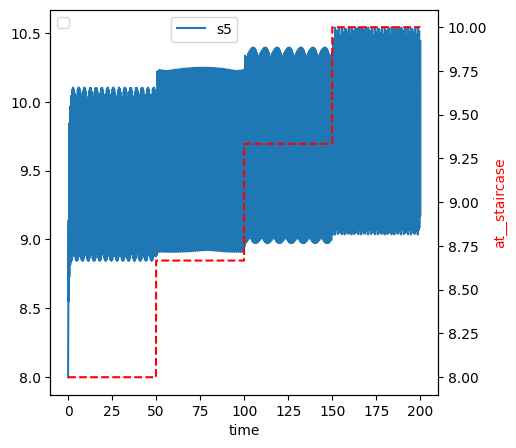

In [8]:
WOLF_PR = WOLF_SYS.plotStaircaseResponse(initial_value=8, final_value=10, num_step=4,
                                         end_time=200, 
                                             figsize=(5, 5), legend_crd=(0.5, 1))
WOLF_TS = WOLF_PR.time_series

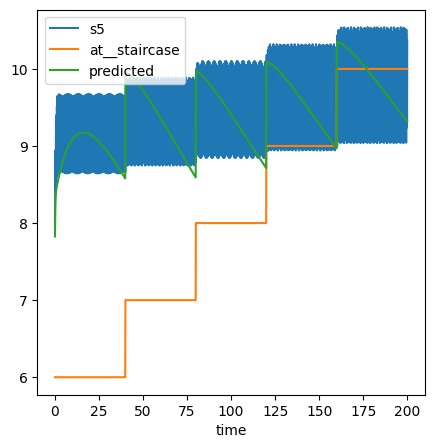

In [29]:
builder = WOLF_CTLSB.makeSISOTransferFunctionBuilder()
fitter_result = builder.fitTransferFunction(4, 4, initial_value=6, final_value=10,          
            end_time=200)
ctl.plotOneTS(fitter_result.time_series, figsize=(5,5), legend_crd=(0.4, 1))

In [30]:
fitter_result.minimizer_result.message

'Fit succeeded.'

In [31]:
fitter_result.transfer_function

TransferFunction(array([3.00332467e-02, 2.10530987e-01, 2.13705625e-02, 5.92417130e-05]), array([2.30256177e-02, 1.51138516e-01, 1.30185166e-02, 1.01578525e-04]))

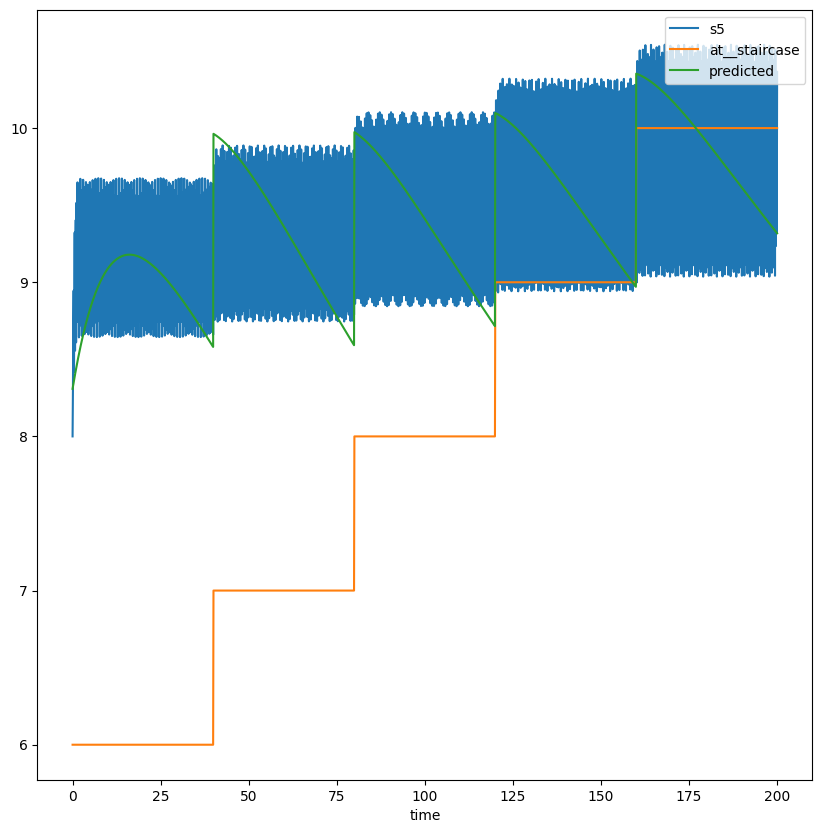

In [24]:
ctl.plotOneTS(fitter_result.time_series)

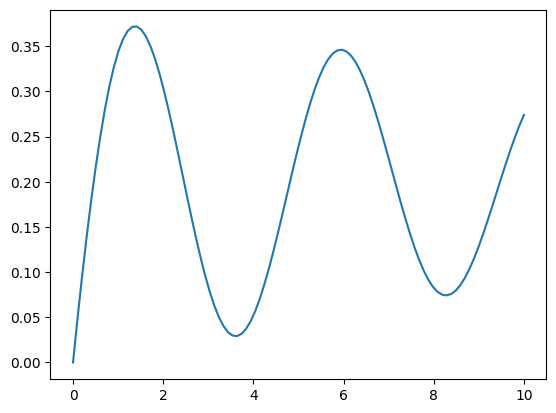

In [11]:
times = np.linspace(0, 10, 100)
times, y_vals = control.forced_response(tf, T=times, X0=0, U=1)     
plt.plot(times, y_vals)

In [12]:
def makeTransferFunction(tf_dct):
    """
    Constructs a transfer function from a dictionary representation.
    
    tf_dct: dict
        key=n<int>: numerator coefficient for int-th element
        key=d<int>: denominator coefficient for int-th element
        
    Usage:
        tf_dct = {"n0": 1, "n1": 1, "d1": 3, "d0": 1}
        tf = makeTransferFunction(tf_dct)
    """
    def makeVec(letter):
        """
        Creates a vector for the keys are a single letter followed
        by an index.
        
        Parameters
        ----------
        letter: char
        
        Returns
        -------
        np.array
        """
        dct = {int(k[1:]): v for k, v in tf_dct.items() if k[0] == letter}
        size = max([i for i in dct.keys()]) + 1
        arr = list(np.repeat(0, size))
        for idx, value in dct.items():
            arr[idx] = value
        return np.array(arr)
    #
    num_arr = makeVec("n")
    den_arr = makeVec("d")
    return control.TransferFunction(num_arr, den_arr)

# Tests
tf_dct = {"n0": 1, "n1": 1, "d1": 3, "d0": 1}
tf = makeTransferFunction(tf_dct)
assert(tf.zeros()[0] == -1)
assert(tf.poles()[0] == -3)
#
tf_dct = {'n0': 0.1, 'd0': 0.1, 'd1': 0.1}
tf = makeTransferFunction(tf_dct)
print("OK!")

OK!


In [13]:
np.isinf(np.inf)


True

In [14]:
def makeCalculateTransferFunctionResidual(initial_value=0):
    """
    Create a function that calculates the residuals for a SISO transfer function
    approximation.
    
    Parameters
    ----------
    initial_value: float (initial value of the transfer function)
    
    Returns
    -------
    Function
    """
    def calculateTransferFunctionResiduals(parameters, data_in, data_out):
        """
        Computes the residuals for a transfer function.

        Parameters
        ----------
        parameters: lmfit.Parameters
            n<int>: numerator coefficient for int-th element
            d<int>: denominator coefficient
        data_in: (list-float, list-float) (times, input signal)
        data_out: array-float (calibration data)
        Returns
        -------
        float
        """
        times, inputs = data_in
        tf = makeTransferFunction(parameters.valuesdict())
        times, y_arr = control.forced_response(tf, T=times, U=inputs)
        residuals = data_out - y_arr
        is_bads = [np.isnan(v) or np.isinf(v) or (v is None) for v in residuals]
        is_bad = any(is_bads)
        if is_bad:
            residuals = np.repeat(1e10, len(times))
        return residuals
    #
    return calculateTransferFunctionResiduals

# Tests
times = np.array(WOLF_TS.index)
inputs = WOLF_TS["at__staircase"].values
outputs = WOLF_TS["s5"].values
func = makeCalculateTransferFunctionResidual()
pfit = lmfit.Parameters()
pfit.add(name='n0', value=0.1, min=-10, max=5)
pfit.add(name='d0', value=0.1, min=-10, max=5)
pfit.add(name='d1', value=0.1, min=-10, max=5)
ssq = np.sqrt(sum(func(pfit, (times, inputs), outputs)) **2 )
assert(isinstance(ssq, float))
assert(ssq > 0)
print("OK!")

OK!


## Find the parameters

In [15]:
def makeParameters(num_numerator, num_denominator):
    pfit = lmfit.Parameters()
    for idx in range(num_numerator):
        pfit.add(name='n%d' % idx, value=0.1, min=-10, max=5)
    for idx in range(num_denominator):
        pfit.add(name='d%d' % idx, value=0.1, min=-10, max=5)
    return pfit

# Tests
pfit = makeParameters(3, 4)
assert(len(pfit.valuesdict()) == 7)
print("OK!")

OK!


In [16]:
inputs = WOLF_TS["at__staircase"].values
times = np.array(WOLF_TS.index)
data_out = WOLF_TS["s5"].values

inputs = WOLF_TS["at__staircase"].values
times = np.array(WOLF_TS.index)
data_out = WOLF_TS["s5"].values
data_in = (times, inputs)
                 

func = makeCalculateTransferFunctionResidual()
if False:
    pfit = lmfit.Parameters()
    pfit.add(name='n0', value=0.1, min=-10, max=5)
    pfit.add(name='n1', value=0.1, min=-10, max=5)
    pfit.add(name='n2', value=0.1, min=-10, max=5)
    pfit.add(name='n3', value=0.1, min=-10, max=5)
    pfit.add(name='d0', value=0.1, min=-10, max=5)
    pfit.add(name='d1', value=0.1, min=-10, max=5)
    pfit.add(name='d2', value=0.1, min=-10, max=5)
    pfit.add(name='d3', value=0.1, min=-10, max=5)
pfit = makeParameters(1, 3)
ssq = func(pfit, (times, inputs), outputs)

mini = lmfit.Minimizer(func, pfit, fcn_args=(data_in, data_out))
out = mini.leastsq()
print(out.params.valuesdict())

{'n0': 0.10277847569189191, 'd0': 0.24953526868542397, 'd1': 0.8576725958482196, 'd2': 0.09723379816424149}


In [17]:
[(k, v.stderr) for k,v in out.params.items()]

[('n0', 37620.707532040586),
 ('d0', 91711.62621919604),
 ('d1', 313939.64501184865),
 ('d2', 35591.16563876152)]


            0.1028
-------------------------------
0.2495 s^2 + 0.8577 s + 0.09723



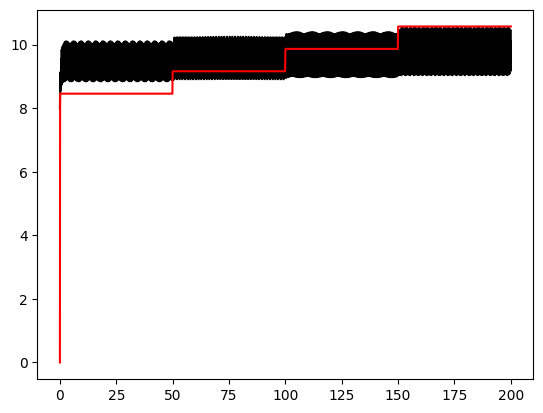

In [18]:
tf = makeTransferFunction(out.params.valuesdict())
_, data_pred = control.forced_response(tf, T=times, U=inputs)
print(tf)
xv = times/1000.
plt.plot(xv, data_out, color="black")
plt.plot(xv, data_pred, color="red")

In [19]:
tf.poles()

array([-3.31970178+0.j, -0.11737787+0.j])

# Example of using lmfit

In [20]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian


def residual(pars, x, data):
    model = (gaussian(x, pars['amp_g'], pars['cen_g'], pars['wid_g']) +
             lorentzian(x, pars['amp_l'], pars['cen_l'], pars['wid_l']))
    return model - data

np.random.seed(0)
x = np.linspace(0, 20.0, 601)

data = (gaussian(x, 21, 6.1, 1.2) + lorentzian(x, 10, 9.6, 1.3) +
        np.random.normal(scale=0.1, size=x.size))

pfit = Parameters()
pfit.add(name='amp_g', value=10)
pfit.add(name='amp_l', value=10)
pfit.add(name='cen_g', value=5)
pfit.add(name='peak_split', value=2.5, min=0, max=5, vary=True)
pfit.add(name='cen_l', expr='peak_split+cen_g')
pfit.add(name='wid_g', value=1)
pfit.add(name='wid_l', expr='wid_g')

mini = Minimizer(residual, pfit, fcn_args=(x, data))
out = mini.leastsq()
best_fit = data + out.residual

In [21]:
pfit.valuesdict().keys()

dict_keys(['amp_g', 'amp_l', 'cen_g', 'peak_split', 'cen_l', 'wid_g', 'wid_l'])

# mTOR transfer function

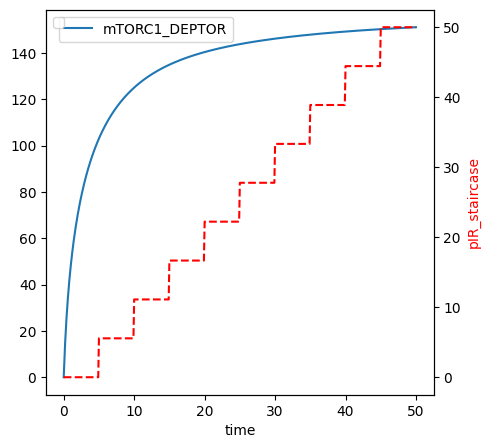

In [22]:
# Make some data
plot_response = MTOR_SYS.plotStaircaseResponse(initial_value=0, final_value=50, num_step=10, end_time=50, 
                                             figsize=(5, 5), legend_crd=(0.5, 1))